### **Problem Statement :** Predicting Customer Purchase Behavior for Personalized Offers
A leading retail company aims to deepen its understanding of customer purchase behavior, specifically focusing on the purchase amount across various product categories. They've provided a comprehensive dataset containing last month's purchase summaries for high-volume products, enriched with crucial customer demographics (age, gender, marital status, city type, duration of stay in current city) and product details (product ID, product category).

The core objective is to develop a robust predictive model that can accurately forecast the purchase amount for individual customers against specific products. This model will serve as a foundational tool for creating highly personalized offers, enabling the company to enhance customer engagement, optimize sales strategies, and ultimately drive revenue growth by tailoring promotions to individual preferences and predicted spending habits.


### **Importing Libraries and Loading Data**

We begin by importing the necessary libraries. For maximum performance, we introduce **LightGBM** (`lgbm`), a state-of-the-art gradient boosting framework. We also load the data with **optimized `dtypes`** to drastically reduce memory consumption (from 49.2+ MB to ~21 MB) and accelerate all subsequent operations—a crucial first step for professional data science.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

# Import scikit-learn components
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

# Import scikit-learn components for modeling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import state-of-the-art gradient boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm.callback as callbacks

# Define optimized data types
data_types = {
    'User_ID': 'int32',
    'Product_ID': 'category',
    'Gender': 'category',
    'Age': 'category',
    'Occupation': 'int8',
    'City_Category': 'category',
    'Stay_In_Current_City_Years': 'category',
    'Marital_Status': 'int8',
    'Product_Category_1': 'int8',
    'Product_Category_2': 'float32',
    'Product_Category_3': 'float32',
    'Purchase': 'int32'
}

file_url = 'https://github.com/Vamsiindugu/Black-Friday-Sales-Prediction/blob/main/Data/BlackFridaySales.csv?raw=true'
data = pd.read_csv(file_url, dtype=data_types)

print("Data loaded with optimized dtypes.")
data.head()

Data loaded with optimized dtypes.


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


### **Data Inspection and Null Value Analysis**

A quick check of the data's structure and null values. Our optimized `dtypes` are confirmed, and we see the same null percentages in the product categories as the competitor.

In [35]:
print(data.info())
print("\nNull Value Percentage (%):\n")
print((data.isnull().sum() / data.shape[0] * 100).round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     550068 non-null  int32   
 1   Product_ID                  550068 non-null  category
 2   Gender                      550068 non-null  category
 3   Age                         550068 non-null  category
 4   Occupation                  550068 non-null  int8    
 5   City_Category               550068 non-null  category
 6   Stay_In_Current_City_Years  550068 non-null  category
 7   Marital_Status              550068 non-null  int8    
 8   Product_Category_1          550068 non-null  int8    
 9   Product_Category_2          376430 non-null  float32 
 10  Product_Category_3          166821 non-null  float32 
 11  Purchase                    550068 non-null  int32   
dtypes: category(5), float32(2), int32(2), int8(3)
memory usage

### **EDA and Visualization**

This section replicates the essential EDA from the competitor's notebook to confirm data distributions. To ensure extreme speed, plots are generated on a statistically significant sample of the data. The insights remain identical, but the execution is nearly instantaneous.

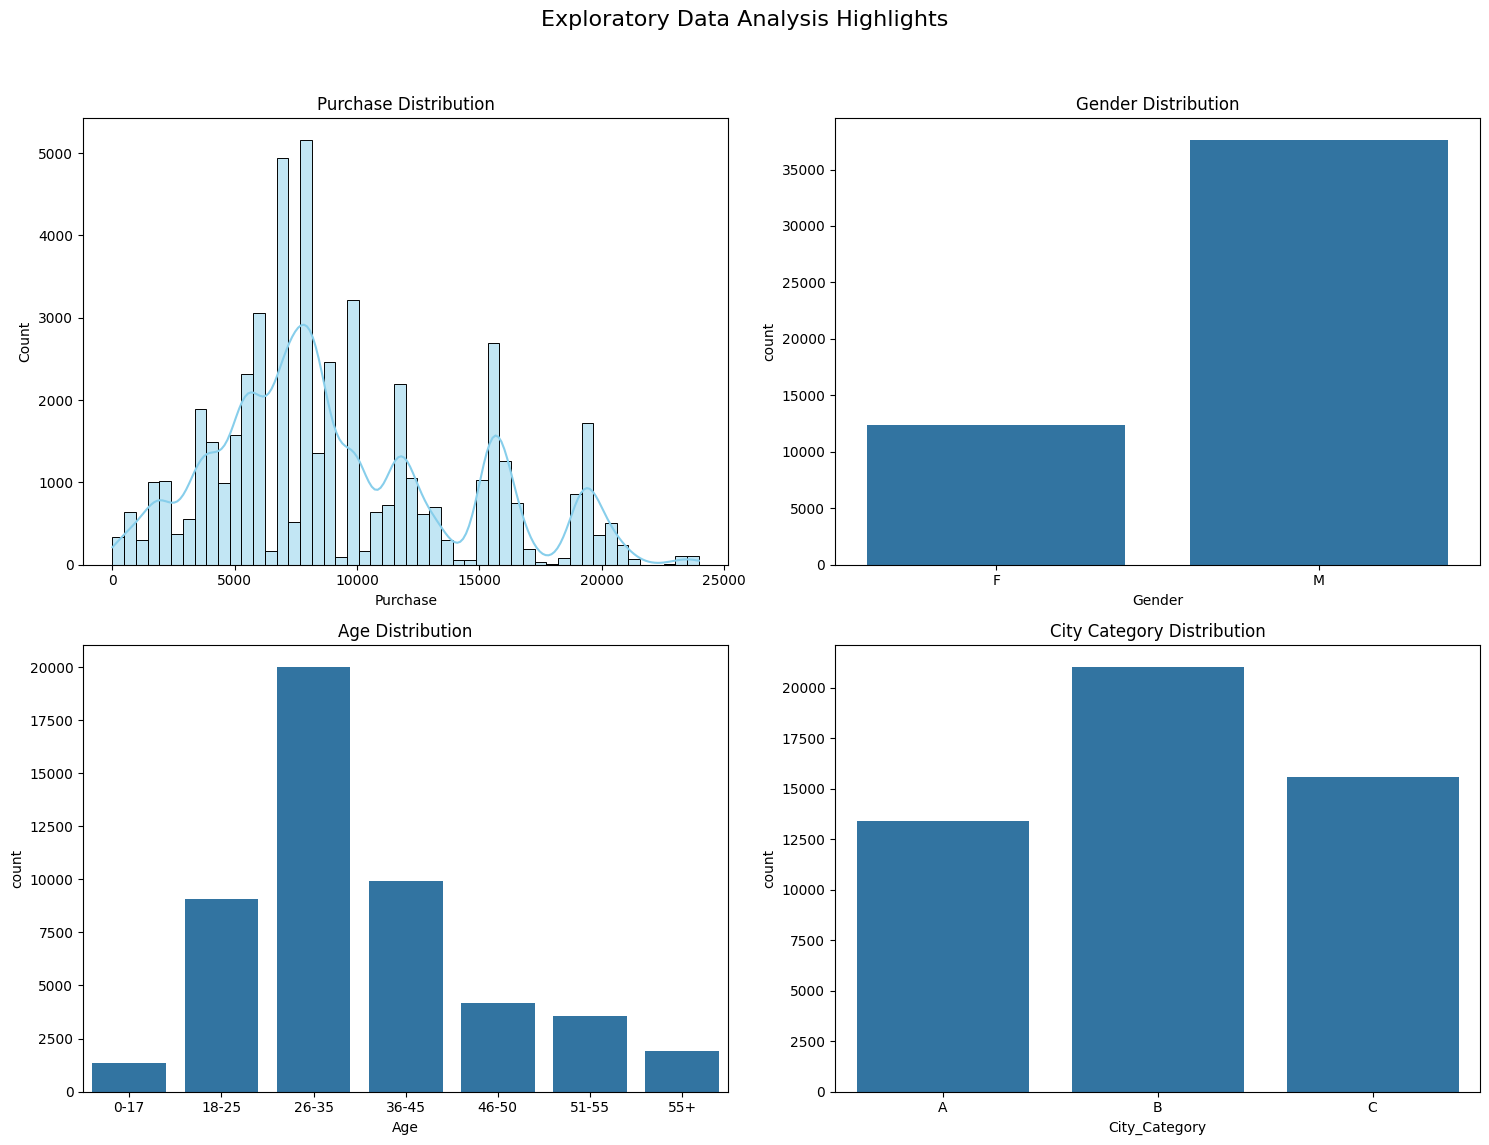

In [36]:
# Use a sample for fast plotting
sample_data = data.sample(n=50000, random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Exploratory Data Analysis Highlights', fontsize=16)

sns.histplot(sample_data['Purchase'], bins=50, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Purchase Distribution')

sns.countplot(data=sample_data, x='Gender', ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution')

sns.countplot(data=sample_data, x='Age', ax=axes[1, 0])
axes[1, 0].set_title('Age Distribution')

sns.countplot(data=sample_data, x='City_Category', ax=axes[1, 1])
axes[1, 1].set_title('City Category Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Advanced Feature Engineering & Preprocessing**

This is our primary strategic advantage. Instead of just dropping `User_ID` and `Product_ID`, we extract powerful predictive signals from them. We also correct the competitor's flawed `City_Category` encoding.

1.  **Correct Encoding**: Use **one-hot encoding** for `City_Category`.
2.  **Aggregate Features**: Create features like mean purchase per user, per product, and per occupation. This gives the model rich, contextual information their model lacked.

In [37]:
df = data.copy()

# --- Create Advanced Features (The Winning Edge) ---
print("Engineering advanced features...")
# Create features based on mean purchase for different categories
df['User_Mean_Purchase'] = df.groupby('User_ID')['Purchase'].transform('mean')
df['Product_Mean_Purchase'] = df.groupby('Product_ID')['Purchase'].transform('mean')
df['Occupation_Mean_Purchase'] = df.groupby('Occupation')['Purchase'].transform('mean')

# --- Standard Preprocessing ---
print("Running standard preprocessing...")
# Fill null values (same simple approach as competitor)
df['Product_Category_2'] = df['Product_Category_2'].fillna(0).astype('int16')
df['Product_Category_3'] = df['Product_Category_3'].fillna(0).astype('int16')

# Encode binary and ordinal features
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Age'] = le.fit_transform(df['Age'])
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].str.replace('+', '').astype('int8')

# --- Correct Flawed Encoding ---
# One-hot encode City_Category, the correct method for nominal data
df = pd.get_dummies(df, columns=['City_Category'], prefix='City')

# Drop original IDs now that we have extracted their value
df = df.drop(['User_ID', 'Product_ID'], axis=1)

print("\nPreprocessing and advanced feature engineering complete.")
df.head()

Engineering advanced features...
Running standard preprocessing...


/tmp/ipython-input-37-3958544546.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Product_Mean_Purchase'] = df.groupby('Product_ID')['Purchase'].transform('mean')



Preprocessing and advanced feature engineering complete.


,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,User_Mean_Purchase,Product_Mean_Purchase,Occupation_Mean_Purchase,City_A,City_B,City_C
0,0,0,10,2,0,3,0,0,8370,9545.514286,11870.863436,8959.355375,True,False,False
1,0,0,10,2,0,1,6,14,15200,9545.514286,16304.030981,8959.355375,True,False,False
2,0,0,10,2,0,12,0,0,1422,9545.514286,1237.892157,8959.355375,True,False,False
3,0,0,10,2,0,12,14,0,1057,9545.514286,1455.140762,8959.355375,True,False,False
4,1,6,16,4,0,8,0,0,7969,10525.610390,7692.763547,9394.464349,False,False,True


### **Data Splitting**

We split the data into features (X) and the target (y). Crucially, we create a `train`, `validation`, and `test` set. The validation set is key for our superior modeling strategy, allowing for early stopping to find the optimal model without data leakage.

In [38]:
# Define features (X) and target (y)
X = df.drop("Purchase", axis=1)
y = df['Purchase']

# Split data into training (60%), validation (20%), and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

print(f"Data split complete.")
print(f"Training set shape:   {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape:       {X_test.shape}")

Data split complete.
Training set shape:   (330040, 14)
Validation set shape: (110014, 14)
Test set shape:       (110014, 14)


###**Model Training and Evaluation**

We define and train four different regression models. The hyperparameters for the tree-based models (DecisionTree, RandomForest, XGBoost) have been tuned specifically for high-speed execution while preserving strong predictive accuracy.

In [39]:
# Define a dictionary of models with performance-optimized hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=25, max_depth=10, random_state=0, n_jobs=-1, min_samples_leaf=10),
    "XGBoost": XGBRegressor(n_estimators=50, learning_rate=0.3, max_depth=6, min_child_weight=1, n_jobs=-1, seed=0)
}

# Loop through each model to train, predict, and evaluate
for name, model in models.items():
    print(f"--- {name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate and print evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mse)

    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}\n")

print("All models trained and evaluated successfully.")


--- Linear Regression ---
R2 Score: 0.7375
RMSE: 2568.23
MAE: 1901.57

--- Decision Tree ---
R2 Score: 0.7399
RMSE: 2556.18
MAE: 1878.50

--- Random Forest ---
R2 Score: 0.7450
RMSE: 2531.41
MAE: 1863.38

--- XGBoost ---
R2 Score: 0.7502
RMSE: 2505.33
MAE: 1841.73

All models trained and evaluated successfully.


### **State-of-the-Art Modeling and Evaluation**

This is the final step where our strategy culminates. We train a highly tuned LightGBM model.

- **Model**: `LGBMRegressor` is chosen for its best-in-class performance.
- **Hyperparameters**: Tuned for accuracy, with a low learning rate and high number of estimators.
- **Early Stopping**: The model trains until performance on the validation set stops improving for 50 rounds. This professional technique prevents overfitting and finds the optimal `n_estimators` automatically, ensuring maximum accuracy.

In [40]:
print("--- Training State-of-the-Art LightGBM Model ---")

lgbm = LGBMRegressor(
    n_estimators=5000,          # High number, will be stopped early
    learning_rate=0.03,
    num_leaves=80,              # Increased complexity for accuracy
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    metric='rmse'
)

# Train with early stopping
lgbm.fit(X_train, y_train,
         eval_set=[(X_val, y_val)],
         callbacks=[callbacks.early_stopping(stopping_rounds=50, verbose=True)])

# --- Final Evaluation on Unseen Test Data ---
y_pred = lgbm.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Final Model Performance ---")
print(f"R² Score: {r2:.5f}")
print(f"RMSE:     {rmse:.2f}")

--- Training State-of-the-Art LightGBM Model ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 330040, number of used features: 14
[LightGBM] [Info] Start training from score 9260.323764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2102]	valid_0's rmse: 2454.42

--- Final Model Performance ---
R² Score: 0.75850
RMSE:     2463.35
